# CS 109A/AC 209A/STAT 121A Data Science: Homework 5
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, October 26th, 2016 at 11:59pm

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Vocareum Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW4.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Verify your submission by checking your submission status on Vocareum!**

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split as sk_split
%matplotlib inline

In [2]:
import collections

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

Galvin, Owen

### Part (b): Course Number

CS 109a (Extension School)

### Part (c): Who did you work with?

none

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Image Classification

In this problem, your task is to classify images of handwritten digits. 

The data set is provided in the file `dataset_1.txt` and contains 8x8 gray-scale images of hand-written digits, flattened to a 64-length vector. The last column contains the digit. For simplicity, we have only included digits 0, 1 and 3. 

We want you to build a model that can be given the image of a hand-written digit and correctly classify this digit as 0, 1 or 3.

### Part 1(a).  Reduce the data

Images data are typically high dimensional (the image vector has one feature for every pixel). Thus, to make working with image data more tractible, one might first apply a dimension reduction technique to the data.

- Explain why PCA is a better choice for dimension reduction in this problem than step-wise variable selection.


- Choose the smallest possible number of dimensions for PCA that still permits us to perform classification. 

  (**Hint:** how do we visually verify that subgroups in a dataset are easily classifiable?)


- Visualize and interpret the principal components. Interpret, also, the corresponding PCA varaiable values.

#### Task: Explain why PCA is a better choice for dimension reduction in this problem than step-wise variable selection.

My first thought is that step-wise would be inferior for the sheer number of steps, literally, involved in doing the computation. These images are only 8x8 but most image recognition would inolve much larger pictures with many more pixels/predictors. Then I'm also not sure how a given variable would have its signifigance judged. It may be more that the domain is entirely different from things like loan defaults, but I don't see it working as well with images. And related to that, probably a lot more room for false significance.  
More specifically I just came across the lecture slides where it mentions step-wise selection via p-values, when you have many predictors, is likely to result in subsets that are not really significant - of course any decent sized image will indeed have many predictors.  
PCA on the other hand is often one of the first approaces when there are large numbers of predictors presence, much more efficient.


### Step 1: Read in the data and visualize

In [3]:
#Lab 5 code

#Load the data
data = np.loadtxt('datasets/dataset_1.txt', delimiter=',')

#Split into predictor and response, where the first 64 columns represent the vectorized image
#  and the actual digit (0/1/3 is held in the final column)
x = data[:, :-1]
y = data[:, -1]

#Print shapes of predictor and response arrays
print 'predictor matrix shape:', x.shape
print '\t{0} images, each made up of a {1:.0f}x{1:.0f} image stored as a vector of {2} elements'.format(
    x.shape[0], 
    np.sqrt(x.shape[1]),
    x.shape[1])
print 'response array shape:', y.shape

predictor matrix shape: (543L, 64L)
	543 images, each made up of a 8x8 image stored as a vector of 64 elements
response array shape: (543L,)


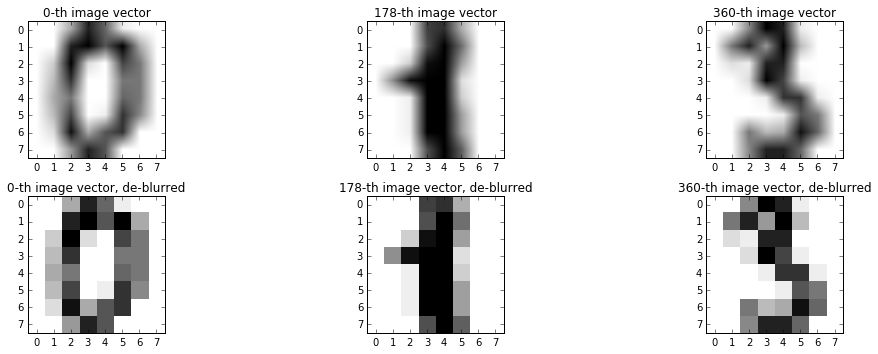

In [4]:
#Lab 5 code, some flexibility improvements in terms of obtaining sample images

idx_zero = np.where(y==0)[0][0]
idx_one = np.where(y==1)[0][0]
idx_three = np.where(y==3)[0][0]

#Plot a couple of images from the dataset
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
ax[0, 0].imshow(x[idx_zero].reshape(8, 8), cmap=plt.cm.gray_r)
ax[0, 0].set_title('{}-th image vector'.format(idx_zero))
ax[0, 1].imshow(x[idx_one].reshape(8, 8), cmap=plt.cm.gray_r)
ax[0, 1].set_title('{}-th image vector'.format(idx_one))
ax[0, 2].imshow(x[idx_three].reshape(8, 8), cmap=plt.cm.gray_r)
ax[0, 2].set_title('{}-th image vector'.format(idx_three))

ax[1, 0].imshow(x[idx_zero].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 0].set_title('{}-th image vector, de-blurred'.format(idx_zero))
ax[1, 1].imshow(x[idx_one].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 1].set_title('{}-th image vector, de-blurred'.format(idx_one))
ax[1, 2].imshow(x[idx_three].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 2].set_title('{}-th image vector, de-blurred'.format(idx_three))

plt.tight_layout()
plt.show()

### Step 2:  Reduce the data

(Lab had an initial approach that involved randomly selecting some preditors and seeing how those did but Homework question directs us to dive right into PCA.)

In [5]:
# Lab 6 code, moved into a function

def pca_subplot(fig, n_components, axes_labels=None, projection=None):
    
    if projection and projection != '3d':
        raise NotImplementedError('only 2d and 3d projections supported')
        
    pca = PCA(n_components)
    pca.fit(x)

    #Project to the data onto the axes
    x_reduced = pca.transform(x)

    #Visualized our reduced data
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    nums = [0,1,3]
    color_map = dict(zip((nums),('b','r','g')))
    for i in nums:
        clr = color_map[i]
        ax.scatter(x_reduced[y==i, 0], x_reduced[y==i, 1], c=clr, color=clr, label='{}'.format(i), marker='${}$'.format(i))
    if axes_labels:
        ax.set_xlabel(axes_labels[0])
        ax.set_ylabel(axes_labels[1])
    else:
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
    if projection == '3d':
        if axes_labels:
            ax.set_zlabel(axes_labels[2])
        else:
            ax.set_zlabel('Component 3')

    ax.set_title('data projected onto the first {} PCA components'.format(n_components))
    # the markers have been set to the datapoint value but they are rather small and increasing
    #   the size would crowd the points, so it makes sense to keep the legend
    ax.legend()

    return ax
  

#### Task: Choose the smallest possible number of dimensions for PCA that still permits us to perform classification. 
Begin with two dimensions and it actually immediately looks like it will function as a decent classifier, can easily see how lines can be drawn between the three groupings. Of course this wouldn't have happened so easily with a different data set, e.g. if the digit information we began with had included a 9 and a 4, there would likely have been a good amount of overlap between those two since they the handwritten versions of each resemble one another.

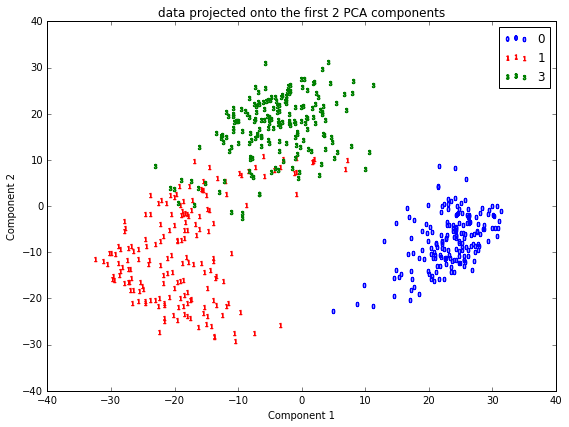

In [6]:
# draw a plot with only the first two pca components
pca_components = 2
fig = plt.figure(figsize=(8, 6))
ax = pca_subplot(fig, pca_components)   
plt.tight_layout()
plt.show()

Even though things were already looking good with only two components, it makes sense to try a PCA fit that is only a little more complex, with three components. There is a chance that a plot will reveal extremely distinct groupings at that level.

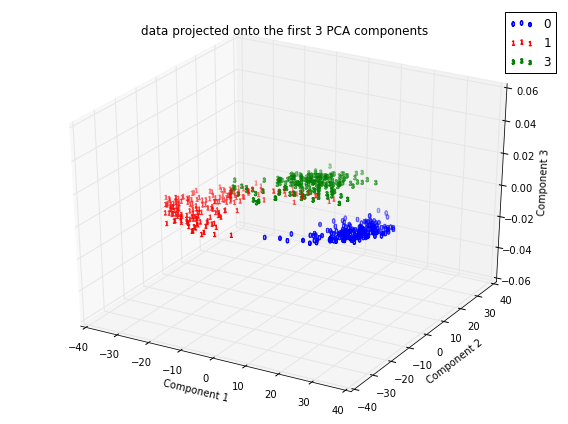

In [7]:
# draw a plot with the first three pca components
pca_components = 3
fig = plt.figure(figsize=(8, 6))
ax = pca_subplot(fig, pca_components, projection='3d')   
plt.tight_layout()
plt.show()

But this is not the case and it would seem the first two PCA components will be good enough for this data set.

#### Task: Visualize and interpret the principal components.

It is rare that principal components can easily be visualized, but these images present just such an opportunity. To do so, begin by looking at the first PCA component with various interpolations, in case one of these interpolation methods reveals something that otherwise might be hidden.

In [8]:
# set some global variables using the number of components decided upon by review
pca = PCA(n_components=2)
pca.fit(x)
x_reduced = pca.transform(x)


Component 1, various interpolation methods


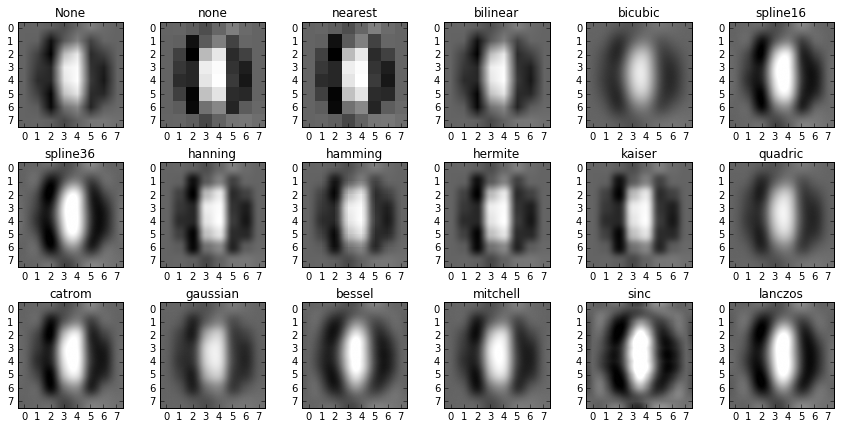

In [9]:
# list of all the available imshow interpolation methods
all_methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']
rows = 3
methods = np.array_split(all_methods, rows)

print 'Component 1, various interpolation methods'
fig, ax = plt.subplots(3, len(methods[0]), figsize=(12, 6))
# COMPONENT 1
for j, method_list in enumerate(methods):
    for i,method in enumerate(method_list):
        #Lab 6 code snippet
        ax[j, i].imshow(pca.components_[0].reshape(8,8), cmap=plt.cm.gray_r, interpolation=method)
        ax[j, i].set_title(method)

plt.tight_layout()
plt.show()

Can refer back to above if necessary, but probably makes sense to begin with default (None) and then go with whichever ones appear most distint from that baseline.

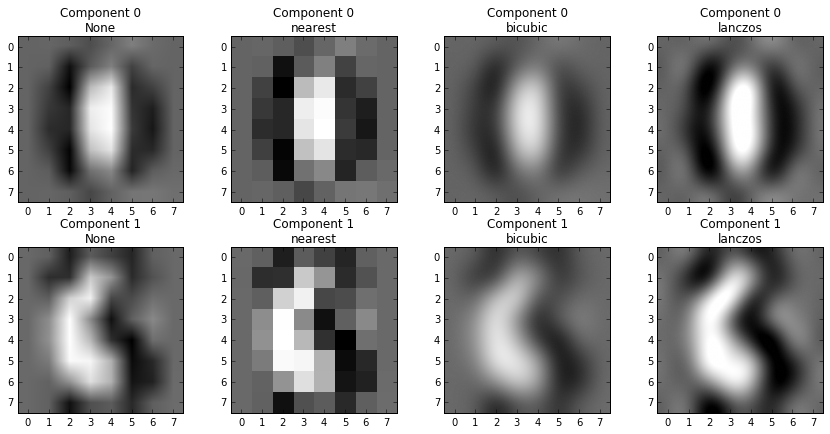

In [10]:
#Lab 6 code, with enhancements

methods = [None, 'nearest', 'bicubic','lanczos']
#Display the principal components of PCA as digital images
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
for j, method in enumerate(methods):
    for i in xrange(2):
        ax[i, j].imshow(pca.components_[i].reshape(8,8), cmap=plt.cm.gray_r, interpolation=method)
        ax[i, j].set_title('Component {}\n{}'.format(i, method)) 

plt.tight_layout()
plt.show()    

#### Task: Interpret, also, the corresponding PCA variable values.

In each of the interpolations above the results essentially matched what was found in the labs = the first principal component looks like the 0 digit and the 2nd component looks like a 3. Now to go back to the earlier 2-PCA component scatter plot, add some relevant axes labels, and a set of lines drawn where the value for each component = 0.

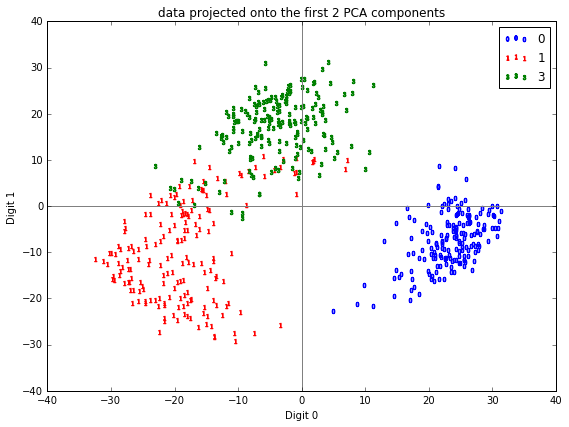

In [11]:
# Lab 6 code + lines added

# draw a plot with only the first two pca components
axes_labels = ['Digit 0', 'Digit 1']
pca_components = 2
fig = plt.figure(figsize=(8, 6))
ax = pca_subplot(fig, pca_components, axes_labels=axes_labels)   
#add some axes at 0 for both 'Digit 0' and 'Digit 1'
plt.axvline(x=0, color='gray')
plt.axhline(y=0, color='gray')

plt.tight_layout()
plt.show()

Looking at the above plot, the most distinct relationship between the signage on actual values and the viz of the  components (as represented on the plot by the axes labels), is in the lower left. In that quadrant we see something like 90% of the data points where the true digit is 1, and also note there are a very few of the actual-3's in there. Since we could see from the visualization that the two components are essentially (really, there essence is), 0 and 3, it makes sense that the 1's appear in this area, where both 'Digit 1' and 'Digit 0' PCA values are negative.

Then if we look at the bottom right quadrant, we can see that almost all of the true-0 data points reside here. This makes sense as this is the area where 'Digit 0', aka Component 0, values are positive and the values for the other component ('Digit 3', aka Component 1) are negative. This is the area where 'Digit 0' is truthy and 'Digit 3' is ... non-truthy. Also notable is how distinct this cluster is compared to the true-1 & true-3's. Looking at the PCA visualizations again, and comparing to the initial images I want to say the 0 pics are more essentially-0 than the 3 pics are essentially-3. Or at least that is what I would expect going by they data. Truthfully I don't really see that unless I concentrate on a dark vertical line where 1 resides and see that the zero is definitely less-dark in that area compared to the 3.

Finaly, the top left quadrant represents PCA values where 'Digit 0' is negative and 'Digit 3' is positive. Logically, and as revealed by the chart, this is the area where the majority of the true-3 data points live. These datapoints spread a bit into the area where 'Digit 0' is positive, perhaps because the pixels from many of the true-3 datapoints have curved regions that intersect with the prototypical 0. Something similar happens with true-0 data points, to the extent that they cluster relative close to the horizontal line, with some crossing over into positive-'Digit 3' terrritory.


### Part 1(b). Build a classifier

So far, we have only learned models that distinguishes between two classes. Develop and implement a **simple and naive** method of distinguishing between the three digits in our reduced dataset using binary classifiers. 

In [12]:
# Lab 6 code, minor variable renaming, some logic encapsulated into function

def fit_log_model(x_binary, y_binary):
    logistic_model = LogReg()
    logistic_model.fit(x_binary, y_binary)
    
    return logistic_model
    

###Build a classifier to distinguish between 0 and 1

#Remove all instances of class 3
x_binary = x_reduced[y != 3, :]
#Remove all instances of class 3
y_binary = y[y != 3]

#Fit logistic regression model for 0 vs 1
logistic_0vs1 = fit_log_model(x_binary, y_binary)

###Build a classifier to distinguish between 1 and 3
#Remove all instances of class 0
x_binary = x_reduced[y != 0, :]
#Remove all instances of class 0
y_binary = y[y != 0]

#Fit logistic regression model for 1 vs 3
logistic_1vs3 = fit_log_model(x_binary, y_binary)

###Build a classifier to distinguish between 0 and 3
#Remove all instances of class 1
x_binary = x_reduced[y != 1, :]

#Remove all instances of class 1
y_binary = y[y != 1]

#Fit logistic regression model for 0 vs 3
logistic_0vs3 = fit_log_model(x_binary, y_binary)

#Predict a label for our dataset using each binary classifier
y_pred_0vs1 = logistic_0vs1.predict(x_reduced)
y_pred_1vs3 = logistic_1vs3.predict(x_reduced)
y_pred_0vs3 = logistic_0vs3.predict(x_reduced)

#Now, for each image, we have THREE predictions!
#To make a final decision for each image, we just take a majority vote.
n = x_reduced.shape[0]
y_votes = np.zeros((n, 3))

#Votes for 0
y_votes[y_pred_0vs1 == 0, 0] += 1
y_votes[y_pred_0vs3 == 0, 0] += 1

#Votes for 1
y_votes[y_pred_0vs1 == 1, 1] += 1
y_votes[y_pred_1vs3 == 1, 1] += 1

#Votes for 3
y_votes[y_pred_0vs3 == 3, 2] += 1
y_votes[y_pred_1vs3 == 3, 2] += 1

#For each image, label it with the class that get the most votes
y_pred = y_votes.argmax(axis = 1)

#Relabel class 2 as class 3
y_pred[y_pred == 2] = 3


### Part 1(c). Build a better one
Asses the quality of your classifier.


- What is the fit (in terms of accuracy or R^2) of your model on the reduced dataset? Visually assess the quality of your classifier by plotting decision surfaces along with the data. Why is visualization of the decision surfaces useful? What does this visualization tell you that a numberical score (like accuracy or R^2) cannot?


- What are the draw backs of your approach to multi-class classification? What aspects of your method is contributing to these draw backs, i.e. why does it fail when it does? 

  (**Hint:** make use your analysis in the above; think about what happens when we have to classify 10 classes, 100 classes)
 
 
- Describe a possibly better alternative for fitting a multi-class model. Specifically address why you expect the alternative model to outperform your model.

  (**Hint:** How does ``sklearn``'s Logistic regression module handle multiclass classification?).

#### Task: What is the fit (in terms of accuracy or R^2) of your model on the reduced dataset?

In [13]:
#Accuracy of our predictions
print 'R^2 Accuracy of combined model:', np.mean(y == y_pred)

R^2 Accuracy of combined model: 0.935543278085


#### Task: Visually assess the quality of your classifier by plotting decision surfaces along with the data. 

The R^2 is certainly quite high but we are only dealing with three possible Y values here, across two PCA dimensions. Creating a plot that includes the decision boundaries prescribed by the three logistic regression models will

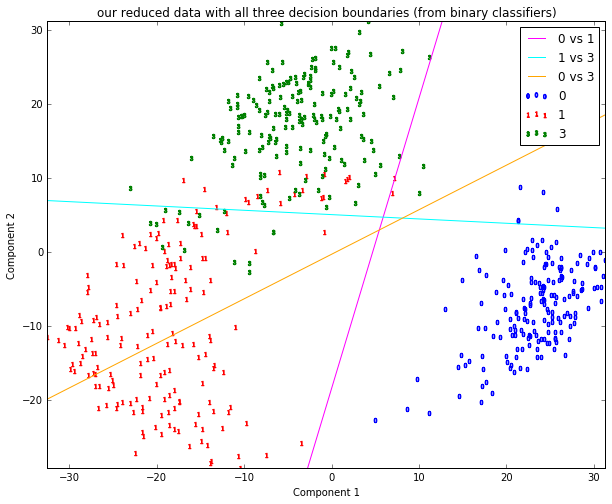

In [14]:
#--------  fit_and_plot_model
# A function to fit a binary LogReg model and visualize it
# Input: 
#      model (LogReg model)
#      ax (axes object for plotting)
#      legend_label (legend label for the plot)

def plot_model(model, ax, legend_label, color):
    #Get the coefficients from logistic regression model
    coef = model.coef_[0]
    intercept = model.intercept_
    
    #Find the max and min horizontal values of our data
    x_0 = np.min(x_reduced[:, 0])
    x_1 = np.max(x_reduced[:, 0])
        
    #Plug int the max and min horizontal values of our data into the equation
    #of the line defined by the coefficients
    y_0 = (-intercept - coef[0] * x_0) / coef[1]
    y_1 = (-intercept - coef[0] * x_1) / coef[1]

    #Plot a line through the pair of points we found above
    ax.plot([x_0, x_1], [y_0, y_1], label=legend_label, color=color)


fig, ax = plt.subplots(1, 1, figsize=(10, 8))

#Scatter plot of our data
ax.scatter(x_reduced[y==0, 0], x_reduced[y==0, 1], color='b', label='0', marker='$0$')
ax.scatter(x_reduced[y==1, 0], x_reduced[y==1, 1], color='r', label='1', marker='$1$')
ax.scatter(x_reduced[y==3, 0], x_reduced[y==3, 1], color='g', label='3', marker='$3$')

#Plot decision boundaries for 0 vs 1
plot_model(logistic_0vs1, ax, '0 vs 1', 'magenta')
#Plot decision boundaries for 1 vs 3
plot_model(logistic_1vs3, ax, '1 vs 3', 'cyan')
#Plot decision boundaries for 0 vs 3
plot_model(logistic_0vs3, ax, '0 vs 3', 'orange')

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_xlim([np.min(x_reduced[:,0]), np.max(x_reduced[:,0])])
ax.set_ylim([np.min(x_reduced[:,1]), np.max(x_reduced[:,1])])
ax.set_title('our reduced data with all three decision boundaries (from binary classifiers)')
ax.legend()
plt.show()

#### Task: Why is visualization of the decision surfaces useful?

One main issue that visualization could help identify is that of overfitting. It might not be such an issue with the inflexible simple logistic regression models developed in this example but one can certainly envision curved decision boundary lines that do their very best to distinguish between various digits. And then if we applied that more flexible model, which could have a very high R^2, to a new set of data it could fail miserably as that model was very strongly tied to the initial data set.


#### Task: What are the draw backs of your approach to multi-class classification? What aspects of your method is contributing to these draw backs, i.e. why does it fail when it does?  
(Hint: make use your analysis in the above; think about what happens when we have to classify 10 classes, 100 classes)


There is of course the fact that the model may fail when the decision boundaries cannot be so cleanly drawn, when there is more crossover between the various classes, but that is likely a problem with any classifier, I point out in case there are approaches that would be better if we were trying to distinguish between a zero and a capital letter O.
But the most obvious drawback is computational in nature, where creating two-way models between the three available classes was feasible in such a low dimensionality setting, i.e. we only needed: 

    #Fit logistic regression model for 0 vs 1
    logistic_0vs1 = fit_log_model(x_binary, y_binary)
    #Fit logistic regression model for 1 vs 3
    logistic_1vs3 = fit_log_model(x_binary, y_binary)
    #Fit logistic regression model for 0 vs 3
    logistic_0vs3 = fit_log_model(x_binary, y_binary)

The number of models needed for a given number k predictors is n choose k, for this problem that came down to only 3 models to create. If we were to go up to the full 10 digit range, this approach would require 45 combinations of linear models. Switching to equivalent alphabetical approach might be around 52 choose 2 results in 1326 combinations. (52 to cover lower and upper-case letters and 'around' because maybe the intra-character variants might be done differently, e.g. there are two general ways of writing a lower-case a.)


#### Task: Describe a possibly better alternative for fitting a multi-class model. Specifically address why you expect the alternative model to outperform your model.  
(Hint: How does sklearn's Logistic regression module handle multiclass classification?).

A different approach would be what is known as "one-vs-other" or also "one-vs-rest", where two of the classes are combined and compared to the holdout. Three different models would be necessary:
    1. predict 0 from combined class of 1 and 3
    2. predict 1 from combined class of 0 and 3
    3. predict 3 from combined class of 0 and 1
    
I'm not sure if in this particular scenario (0 vs. 1 vs. 3) that this alternative would necessarily be superior to the one that has been implemented, as I believed its main advantage was computational in nature. We only require n classes with one-vs-rest, where n is the number of categories. That is 3 here but also 3 with teh implemented approach. Now if we go up to 10, we are already needing 45 models for the one-to-one as described in last answer. But with one-vs-rest we only need 10. The disparity only grows as the number of categories grows. Less time spent computing means more time to do other meaningful model improvements, including cross-validation etc.

## Problem 2. Sentiment Analysis

In this problem, you will explore how to predict the underlying emotional tone of textual data - this task is called sentiment analysis. 

You will be using the dataset in the file `dataset_2.txt`. In this dataset, there are 1382 posts containing textual opinions about Ford automobiles, along with labels indicating whether the opinion expressed is positive or negative. 

Given a new post about an automobile, your goal is to predict if the sentiment expressed in the new post is positive or negative. For this task you should implement a *regularized* logistic regression model.

Produce a report summarizing your solution to this problem:

- Your report should address all decisions you made in the "Data Science Process" (from Lectures #0, #1, #2):

   a. Data collection & cleaning
   
   b. Data exploration
   
   c. Modeling
   
   d. Analysis  
   
   e. Visualization and presentation  


- Your report should be informative and accessible to a **general audience with no assumed formal training in mathematics, statistics or computer science**.


- The exposition in your report, not including code, visualization and output, should be at least three paragraphs in length (you are free to write more, but you're not required to).

Structure your presentation and exposition like a professional product that can be submitted to a client and or your supervisor at work.

### Report

To begin the sentiment analysis project I first reviewed the raw data in a simple text editor, to take basic stock of the data. As long as a data source is not extremely large, this is a common first-step sanity check. It is always possible looks nothing like what has been described to you. In this case it looked to be normal english language text with a comma delimiter. A quick review showed there to be 1382 rows, with a single header describing the data present on each line. Then a quick count of comma characters showed there to be 1383, implying one comma per line, which would hopefully mean the data could cleanly be loaded. After an initial load using the Python programming language I do a quick look at the as-loaded data, to catch any gross errors that might be present. Then a few quick programmatic checks to confirm we have two columns of data with 1382 rows and that all of the values in the column indicating sentiment are either 'Neg' or 'Pos', i.e. all are classified as being either Negative or Positive. Then a check to see if there are any rows missing data, followed by some summary statistics, e.g. we want to see if more of the negative posts have significantly more words, which could result in misleading analysis of the different sentiments. 

Next I moved on to a more close examination of the data, which includes a review of what are known as "stop words", words that are so common in the English language that they do not contribute to either negative or positive sentiment. The presence those common words, e.g. "a" or "the", can add noise to the process of creating a model and removal of such should allow the model to focus on the words that are more indicative of what we are trying to predict. To come up with stop words I look to see if any very common words are present more often in text that has been characterized as being negative vs. positive, and vice versa. It is not surprising the letter "a" is both common and meaningless for our purposes, while the word "was" is apparently one we want to hold onto, as it is associated with negative sentiment. 

To actually create a first pass at a model, I use a very simple list of noise words, only later circling back to make use of the above exercises. One basic part of the model creation involves splitting the data, into a set of known-text-and-sentiment rows vs. a smaller set that will be used to gauge the accuracy of a model based upon the larger mass of data. After that is a deeper dive into model creation, where we create many models that help average out any random occurences that might occur when splitting the data. For example, since the split is random we might end up with many more rows with negative sentiment in the data we are using to base the model on - unlikely but it happen by chance and we want to be careful. There are also different models to choose from, each of which may perform better than another depending on the data and a variety of other factors. Each model can also be be tuned slighly differently and we need to feed in different values in order to see if the model works better, like rotating a radio know back and forth until the clearest frequency is found - you don't know where exactly that will be until knob is twisted one way and then the other. For each of these different models with different tuning parameters we determine the model's accuracy to see how well it can guess negative or positive sentiment on a set a data it has never seen before. This accuracy score is relatively simply in the end - if it guesses 3 out of 4 correctly, i.e. marks 3 out of 4 as the sentiment truly is, then we get a score = 75%. The best I'm able to come up with is approximately 80%, which is notably better than a 50/50 guess. In one final attempt at improving the model's accuracy I circle back to the stop words work that had been done previously, which allows for a minor improvement.

Finally, I present a list of words that are outstanding in that their presence is a strong indicator of either negative or positive sentiment. In the positive category we can see that Supercrew and Festiva (who knew?) models are highly thought of, as are the Triton and Powerstroke engines. On the downside it seems that there may be problems with gaskets, CV joints, and torque/catalytic converters and people tend top complain about them. Additionally, the Winstar would not appear to be a well thought of model. At the very end are a series of pie charts, running through a subset of negatively and positively associated words, at various levels of significance


### Coding

In [15]:
# load the data in
df = pd.read_csv('datasets/dataset_2.txt', delimiter=',')
df.head()

,class,text
0,Neg,In 1992 we bought a new Taurus and we really ...
1,Neg,The last business trip I drove to San Franci...
2,Neg,My husband and I purchased a 1990 Ford F250 a...
3,Neg,I feel I have a thorough opinion of this truc...
4,Neg,AS a mother of 3 all of whom are still in ca...


In [16]:
# some summary data

print '- See 1382 rows split into two columns, as the initial groundrules had led us to suspect.'
print '  - one common danger when processing text, of having the delimiter embedded in the text itself, is not an issue'
print df.shape
#print df[:1]  # all columns of first row..
print '- As expected, all of the values in the first column are either "Neg" or "Pos"'
print df['class'].unique()
print
print '- Data overall looks good, no null/missing values'
print df.info()
print
print '- Records are evenly divided between positive and negative sentiments'
print df.groupby(['class']).size()
print


- See 1382 rows split into two columns, as the initial groundrules had led us to suspect.
  - one common danger when processing text, of having the delimiter embedded in the text itself, is not an issue
(1382, 2)
- As expected, all of the values in the first column are either "Neg" or "Pos"
['Neg' 'Pos']

- Data overall looks good, no null/missing values
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382 entries, 0 to 1381
Data columns (total 2 columns):
class    1382 non-null object
text     1382 non-null object
dtypes: object(2)
memory usage: 32.4+ KB
None

- Records are evenly divided between positive and negative sentiments
class
Neg      691
Pos      691
dtype: int64



In [17]:
# simply split on whitespace, good enough for summary stats like these

text_lengths = df['text'].apply(lambda t: len(t.split()))
print 'All text'
print '- fewest words: {}'.format(np.min(text_lengths))
print '- most words: {}'.format(np.max(text_lengths))
print '- average number of words: {:.0f}'.format(np.mean(text_lengths))
print

df_pos = df[df['class']=='Pos']
pos_text_lengths = df_pos['text'].apply(lambda t: len(t.split()))
print 'Positive sentiment'
print '- average number of words: {:.0f}'.format(np.mean(pos_text_lengths))
print '- median number of words: {:.0f}'.format(np.median(pos_text_lengths))
print

df_neg = df[df['class']=='Neg']
neg_text_lengths = df_neg['text'].apply(lambda t: len(t.split()))
print 'Negative sentiment'
print '- average number of words: {:.0f}'.format(np.mean(neg_text_lengths))
print '- median number of words: {:.0f}'.format(np.median(neg_text_lengths))
print

print 'Conclusion: Average number of words for both positive and negative text snippets are reasonably close.'
print '  Median values differ more than the averages do but since we are aggregating everything, mean is a better measure.'
print 'Also, as noted earlier, we have equal numbers of both negative and positive observations, so we can '
print '  more easily do comparative analysis.'


All text
- fewest words: 101
- most words: 3802
- average number of words: 449

Positive sentiment
- average number of words: 426
- median number of words: 294

Negative sentiment
- average number of words: 471
- median number of words: 340

Conclusion: Average number of words for both positive and negative text snippets are reasonably close.
  Median values differ more than the averages do but since we are aggregating everything, mean is a better measure.
Also, as noted earlier, we have equal numbers of both negative and positive observations, so we can 
  more easily do comparative analysis.


Ok, the thirty most common words look like things that won't be useful, mostly because they are stop words, words that are common in the english language and are unlikely to add anything to an analysis. The 't' and 's' appear to be from when the original text was cleansed in order to remove punctuation, e.g. "don't" got turned into two words, "don" and "t". A word like "don't" might actually be useful for sentiment analysis but re-assembling a word like that is likely beyond the scope of this assignment.

In [18]:
# lets find the most common words, in furtherance of figuring out a stop word list
# (and also with the idea of further ambitions that never came to fruition due to time constraints)
df_info = df
df_info['words'] = df['text'].apply(lambda t: t.lower().split())
all_words = [word for words in df_info['words'].values for word in words]
counts = collections.Counter(all_words)

df_common = pd.DataFrame(counts.most_common(30), columns=['word','count'])
df_common

,word,count
0,the,38538
1,a,17535
2,i,16707
3,and,15933
4,to,14477
5,it,12831
6,is,9611
7,of,9362
8,in,8475
9,that,7002


In [19]:
# now the 30 words that are most common in the text marked as Pos sentiment
pos_words = [word for words in df_info['words'][df_info['class']=='Pos'].values for word in words]
pos_counts = collections.Counter(pos_words)

df_pos_common = pd.DataFrame(pos_counts.most_common(30), columns=['word','count'])
df_pos_common

,word,count
0,the,18146
1,a,8619
2,i,7948
3,and,7941
4,to,6560
5,it,5881
6,is,5128
7,of,4430
8,in,4106
9,for,3486


In [20]:
# the 30 words that are most common in the text marked as Neg sentiment

neg_words = [word for words in df_info['words'][df_info['class']=='Neg'].values for word in words]
neg_counts = collections.Counter(neg_words)

df_neg_common = pd.DataFrame(neg_counts.most_common(30), columns=['word','count'])
df_neg_common


,word,count
0,the,20392
1,a,8916
2,i,8759
3,and,7992
4,to,7917
5,it,6950
6,of,4932
7,is,4483
8,in,4369
9,that,3833


In [21]:
# seeing how many are in common between top-30 of neg/pos
pos_top_words = set(df_pos_common['word'].values)
neg_top_words = set(df_neg_common['word'].values)
print 'number words in common: {}'.format(len(pos_top_words.intersection(neg_top_words)))
print 'present in top positive words but not negative: {}'.format(pos_top_words.difference(neg_top_words))
print 'present in top negative words but not positive: {}'.format(neg_top_words.difference(pos_top_words))


number words in common: 29
present in top positive words but not negative: set(['has'])
present in top negative words but not positive: set(['at'])


In [22]:
# determine if any of those in common are negatively or positively oriented - in theory only want to
# exclude stop words that are relatively neutral
df_both_counts = pd.merge(df_pos_common, df_neg_common, how='inner', left_on='word', right_on='word')
df_both_counts.columns = ['word','pos_count','neg_count']
df_both_counts['abs_diff'] = abs(df_both_counts['pos_count']-df_both_counts['neg_count'])
df_both_counts['pct_diff'] = df_both_counts['abs_diff']/(df_both_counts['pos_count']+df_both_counts['neg_count'])
df_both_counts

,word,pos_count,neg_count,abs_diff,pct_diff
0,the,18146,20392,2246,0.058280
1,a,8619,8916,297,0.016938
2,i,7948,8759,811,0.048543
3,and,7941,7992,51,0.003201
4,to,6560,7917,1357,0.093735
5,it,5881,6950,1069,0.083314
6,is,5128,4483,645,0.067111
7,of,4430,4932,502,0.053621
8,in,4106,4369,263,0.031032
9,for,3486,3268,218,0.032277


I would point out that 't' appears to be overrepresented on the negative side, perhaps contractions like "won't", "haven't" are more likely used when expressing negative sentiment. Of course I might be missing a whole slew of words in my simple examples. Either way, after all that, I'm going to put the results to the side for a while.

In [23]:
# some lab5 code 

# using stop words from Lab5, as well as a few more
# I've decided to leave the majority of "possible" stop words in for now, since I would think
#  some might actually be more/less common depending on sentiments, revisit later
stop_words = ['and', 'or', 'a', 'an', 'the', 'to', 'it', 'is', 'of']
# skip words present 4 or fewer times, not worth analyzing
vectorizer = CountVectorizer(stop_words=stop_words, min_df=4)
corpus = df['text'].values
x = vectorizer.fit_transform(corpus)
x = x.toarray()
y = df['class'].values


In [24]:
# one test, w/o regularization (C is a very high number)
x_train, x_test, y_train, y_test = sk_split(x, y, test_size=0.30)

logitm = LogReg(C = 1000000)
logitm.fit (x_train, y_train)
print 'accuracy score:', logitm.score (x_test, y_test)



accuracy score: 0.809638554217


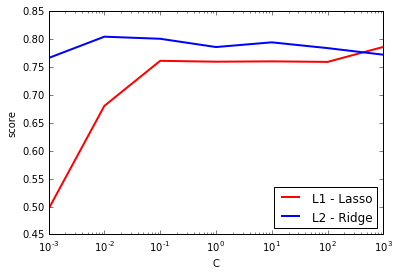

In [25]:

# 0.001 thru 1000
c_values = [10**e for e in range(-3,4)]
R2_l1 = np.zeros([len(c_values), 1])
R2_l2 = np.zeros([len(c_values), 1])
num_samples = 20
# clear out any seed that may have been put into memory
np.random.seed(None)

# for each C value, do a bunch of train/test splits, then store the average of those per-C scores
#  only doing 20 splits per C, for the sake of timeliness
for i, C in enumerate(c_values):
    
    l1_sample_scores = np.zeros([num_samples, 1])
    l2_sample_scores = np.zeros([num_samples, 1])
    for j in xrange(num_samples):
        x_train, x_test, y_train, y_test = sk_split(x, y, test_size=0.30)

        logitm_l1 = LogReg(C = C, penalty = "l1")
        logitm_l1.fit(x_train, y_train)
        l1_sample_scores[j] = logitm_l1.score(x_test, y_test)

        logitm_l2 = LogReg(C = C, penalty = "l2")
        logitm_l2.fit(x_train, y_train)
        l2_sample_scores[j] = logitm_l2.score(x_test, y_test)

    R2_l1[i] = np.mean(l1_sample_scores)
    R2_l2[i] = np.mean(l2_sample_scores)

        
plt.plot(c_values, R2_l1,  color='red', lw=2, label='L1 - Lasso')
plt.plot(c_values, R2_l2,  color='blue', lw=2, label='L2 - Ridge')
plt.xlabel ("C")
plt.ylabel("score")
plt.xscale('log')
plt.legend(loc='best')
#plt.ylim([0.5,1.0])
plt.show()

The above experiment indicates our best approach would be to use L2 (ridge regression) regularization, with a C value of ~0.01. (I've run this a few times and though sometimes it 0.1 was about as close as 0.01, 0.01 was the most consisten winner.)

In [26]:
good_C = 0.01
np.random.seed(109)
x_train, x_test, y_train, y_test = sk_split(x, y, test_size=0.30)
logitm_l2 = LogReg(C = good_C, penalty = "l2")
logitm_l2.fit(x_train, y_train)
print 'Score, with a seed value for consistency:', logitm_l2.score(x_test, y_test)


Score, with a seed value for consistency: 0.797590361446


In [27]:
pred = logitm_l2.predict(x_test)
corr = x_test[pred == y_test]
wrong = x_test[pred != y_test]

print 'Number classified correctly: {}'.format(len(corr))
print 'Number misclassified: {}'.format(len(wrong))
print 'Number of correct guesses ({0}) divided by total number of observations ({1})'.format(len(corr), len(x_test))
print '\t{0}/{1}={2}'.format(len(corr), len(x_test), len(corr)*1.0/len(x_test))


Number classified correctly: 331
Number misclassified: 84
Number of correct guesses (331) divided by total number of observations (415)
	331/415=0.797590361446


In [28]:
print 'Getting back to previous data exploration where we came up with a list of most-common words and did some'
print ' calculations to determine which of these appeared to be indicative of either positive or negative sentiment'
df_both_counts.head(5)

Getting back to previous data exploration where we came up with a list of most-common words and did some
 calculations to determine which of these appeared to be indicative of either positive or negative sentiment


,word,pos_count,neg_count,abs_diff,pct_diff
0,the,18146,20392,2246,0.058280
1,a,8619,8916,297,0.016938
2,i,7948,8759,811,0.048543
3,and,7941,7992,51,0.003201
4,to,6560,7917,1357,0.093735


In [29]:
# the most neutral of the in-common top-30 words = 27
df_common_non_predictive = df_both_counts[df_both_counts['pct_diff'] < 0.1]
non_predictive_stop_words = df_common_non_predictive['word'].values
df_common_non_predictive

,word,pos_count,neg_count,abs_diff,pct_diff
0,the,18146,20392,2246,0.058280
1,a,8619,8916,297,0.016938
2,i,7948,8759,811,0.048543
3,and,7941,7992,51,0.003201
4,to,6560,7917,1357,0.093735
5,it,5881,6950,1069,0.083314
6,is,5128,4483,645,0.067111
7,of,4430,4932,502,0.053621
8,in,4106,4369,263,0.031032
9,for,3486,3268,218,0.032277


In [30]:
# now use those 27 as stop words, I had seen a minor increase in accuracy
stop_words = list(non_predictive_stop_words)
# skip words present 4 or fewer times, not worth analyzing
vectorizer = CountVectorizer(stop_words=stop_words, min_df=4)
corpus = df['text'].values
x = vectorizer.fit_transform(corpus)
x = x.toarray()
y = df['class'].values

good_C = 0.01
np.random.seed(109)
x_train, x_test, y_train, y_test = sk_split(x, y, test_size=0.30)
logitm_l2 = LogReg(C = good_C, penalty = "l2")
logitm_l2.fit(x_train, y_train)
print 'score with potentially better stop word list:', logitm_l2.score(x_test, y_test)

score with potentially better stop word list: 0.804819277108


In [31]:

df_pos_all = pd.DataFrame(pos_counts.items(), columns=['word','count'])
df_neg_all = pd.DataFrame(neg_counts.items(), columns=['word','count'])

df_all_counts = pd.merge(df_pos_all, df_neg_all, how='inner', left_on='word', right_on='word')
df_all_counts.columns = ['word','pos_count','neg_count']
df_all_counts['abs_diff'] = abs(df_all_counts['pos_count']-df_all_counts['neg_count'])
df_all_counts['pct_diff'] = df_all_counts['abs_diff']/(df_all_counts['pos_count']+df_all_counts['neg_count'])
# when creating the model we dropped words that had count < 4, do so here also, for my final display
df_all_counts['pct_diff'][df_all_counts['pos_count']+df_all_counts['neg_count'] > 4]
df_all_counts.head(10)


,word,pos_count,neg_count,abs_diff,pct_diff
0,raining,1,6,5,0.714286
1,yellow,14,12,2,0.076923
2,factory,64,52,12,0.103448
3,four,233,145,88,0.232804
4,preface,1,1,0,0.000000
5,looking,305,239,66,0.121324
6,snowing,1,1,0,0.000000
7,lord,1,1,0,0.000000
8,sinking,1,2,1,0.333333
9,tweaked,3,2,1,0.200000


In [32]:
# most positive words
print 'The most postive-sentiment related words:'
print 'we can see some strange words below but as long as they are consistent, should''nt have an effect on the modeling'
print '- 146ve & 146d appear to be munged versions of "have" & "would" respectively.'
df_most_pos = df_all_counts[df_all_counts['pos_count'] > df_all_counts['neg_count']].sort('pct_diff', ascending=False)
df_most_pos.head(20)

The most postive-sentiment related words:
we can see some strange words below but as long as they are consistent, shouldnt have an effect on the modeling
- 146ve & 146d appear to be munged versions of "have" & "would" respectively.


,word,pos_count,neg_count,abs_diff,pct_diff
6110,supercrew,20,1,19,0.904762
1652,146ve,34,2,32,0.888889
3925,offroad,14,1,13,0.866667
1201,146d,13,1,12,0.857143
3734,powerstroke,12,1,11,0.846154
3181,f250,12,1,11,0.846154
1945,festiva,22,2,20,0.833333
4243,amazingly,11,1,10,0.833333
3421,farm,11,1,10,0.833333
5242,triton,22,2,20,0.833333


In [33]:
# most negative
print 'The most negative-sentiment related words:'
df_most_neg = df_all_counts[df_all_counts['pos_count'] < df_all_counts['neg_count']].sort('pct_diff', ascending=False)
df_most_neg.head(20)


The most negative-sentiment related words:


,word,pos_count,neg_count,abs_diff,pct_diff
944,gaskets,1,32,31,0.939394
3749,converter,1,19,18,0.900000
2659,winstar,1,19,18,0.900000
3011,event,1,18,17,0.894737
3532,expired,2,33,31,0.885714
6048,public,1,16,15,0.882353
3874,aligned,1,16,15,0.882353
5458,rep,1,15,14,0.875000
6287,environment,1,14,13,0.866667
6273,1800,1,13,12,0.857143



Some of the words associated with negative sentiment are displayed below, along with what percent of those words appeared 
negative vs. positive posts. 
NOTE: the words displayed skip over many words in between, i.e. there are about 15 words more negative than "profit" but 
equal or less negative than "gaskets". Jumping over the words makes for a more meaningful display since otherwise 
all the pies would look quite similar.



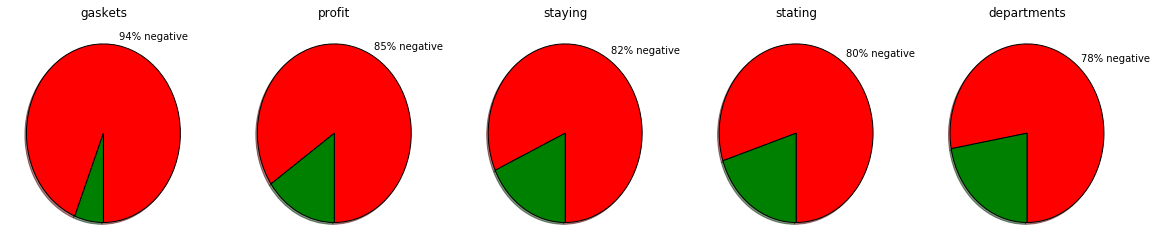

In [34]:
print '''
Some of the words associated with negative sentiment are displayed below, along with what percent of those words appeared 
negative vs. positive posts. 
NOTE: the words displayed skip over many words in between, i.e. there are about 15 words more negative than "profit" but 
equal or less negative than "gaskets". Jumping over the words makes for a more meaningful display since otherwise 
all the pies would look quite similar.
'''

fig = plt.figure(figsize=(20, 4))

step = -1
i = 1
for index, row in df_most_neg.head(75).iterrows():
    step+=1
    if step % 15 != 0:
        continue
    #rint row['word'], row['pct_diff'], 1-row['pct_diff']
    ax1 = fig.add_subplot(150+i)
    ax1.pie([row['pct_diff'], 1-row['pct_diff']],
            labels=['{:.0f}% negative'.format(row['pct_diff']*100),''],
            colors=['red','green'],
            shadow=True, startangle=270
           )
    ax1.set_title(row['word'])
    i+=1 
    

Similar display for positively associated words


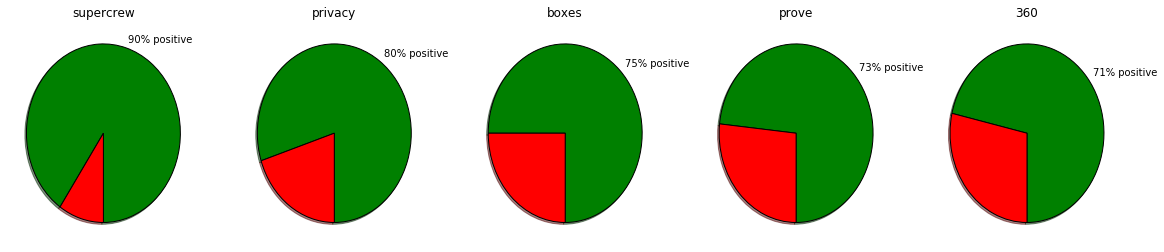

In [35]:
print 'Similar display for positively associated words'

fig = plt.figure(figsize=(20, 4))

step = -1
i = 1
for index, row in df_most_pos.head(75).iterrows():
    step+=1
    if step % 15 != 0:
        continue
    ax2 = fig.add_subplot(150+i)
    ax2.pie([row['pct_diff'], 1-row['pct_diff']],
            labels=['{:.0f}% positive'.format(row['pct_diff']*100),''],
            colors=['green','red'],
            shadow=True, startangle=270
           )
    ax2.set_title(row['word'])
    i+=1 

In [36]:
df_most_pos.head(10)

,word,pos_count,neg_count,abs_diff,pct_diff
6110,supercrew,20,1,19,0.904762
1652,146ve,34,2,32,0.888889
3925,offroad,14,1,13,0.866667
1201,146d,13,1,12,0.857143
3734,powerstroke,12,1,11,0.846154
3181,f250,12,1,11,0.846154
1945,festiva,22,2,20,0.833333
4243,amazingly,11,1,10,0.833333
3421,farm,11,1,10,0.833333
5242,triton,22,2,20,0.833333


## Challenge Problem: Automated Medical Diagnosis

In this problem, you are going to build a model to diagnose heart disease. 

The training set is provided in the file ``dataset_3_train.txt`` and there are two test sets: ``dataset_3_test_1.txt`` and ``dataset_3_test_2.txt``. Each patient in the datasets is described by 5 biomarkers extracted from cardiac SPECT images; the last column in each dataset contains the disease diagnosis (1 indicates that the patient is normal, and 0 indicates that the patient suffers from heart disease).

- Fit a logistic regression model to the training set, and report its accuracy on both the test sets. 


- Is your accuracy rate meaningful or reliable? How comfortable would you be in using your predictions to diagnose real living patients? Justify your answers. 

  (**Hint:** How does the performance of your model compare with a classifier that lumps all patients into the same class?)


- Let's call the logistic regression model you learned, ${C}_1$. Your colleague suggests that you can get higher accuracies for this task by using a threshold of 0.05 on the Logistic regression model to predict labels instead of the usual threshold of 0.5, i.e. use a classifier that predicts 1 when $\widehat{P}(Y = 1\,|\, X) \geq 0.05$ and 0 otherwise. Let's call this classifier ${C}_2$. Does ${C}_2$ perform better the two test sets - that is, which one would you rather use for automated diagnostics? Support your conclusion with careful analysis. 


- Generalize your analysis of these two classifiers. Under what general conditions does $C_2$ perform better than ${C}_1$? Support your conclusion with a mathematical proof or simulation


**Hint:** You were told in class that a classifier that predicts 1 when $\widehat{P}(Y = 1 \,|\, X) \geq 0.5$, and 0 otherwise, is the Bayes classifier. This classifier minimizes the classification error rate. What can you say about a classifier that uses a threshold other than $0.5$? Is it the Bayes classifier for a different loss function?


**Hint:** For the first three parts, you might find it useful to analyze the conditional accuracy on each class.